# <a href=https://github.com/fuodorov/kenv>KENV</a> tutorial
The solver of Kapchinsky-Vladimirsky envelope equation for electron beam with space charge.

<a href=mailto:fuodorov1998@gmail.com>V. Fedorov</a>, <a href=mailto:nikdanila@bk.ru>D. Nikiforov</a>, <a href=http://www.inp.nsk.su/~petrenko/>A. Petrenko</a>, (Novosibirsk, 2019)

In [1]:
import numpy as np
import holoviews as hv
hv.extension('matplotlib')

import warnings
warnings.filterwarnings('ignore')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

Some plotting options:

In [2]:
%output size=200 backend='matplotlib' fig='png' dpi=100
%opts Curve Spread [aspect=3 show_grid=True] (linewidth=2 alpha=0.7)
%opts Spread (linewidth=1 alpha=0.4)

In [3]:
import kenv as kv
kv.__version__

'0.0.18'

## Define the simulation

Define accelerator beamline parameters:

In [4]:
acc = kv.Accelerator(z_start=0, z_stop=5, dz=0.01)

Define the accelerating field profile $E_z(z)$:

In [5]:
#              Unique name,  z-position [m],  Ez [MV/m],  Ez(z) profile
acc.add_accel('Acc. 1',      1.5,            -1,         'Ez.dat')
acc.add_accel('Acc. 2',      3.5,            -1,         'Ez.dat')

In [6]:
acc.compile()

Let's plot $E_z(z):$

In [7]:
dim_z  = hv.Dimension('z',  unit='m')
dim_Ez = hv.Dimension('Ez', unit='MV/m', label='$E_z$')

:Curve   [z]   (Ez)
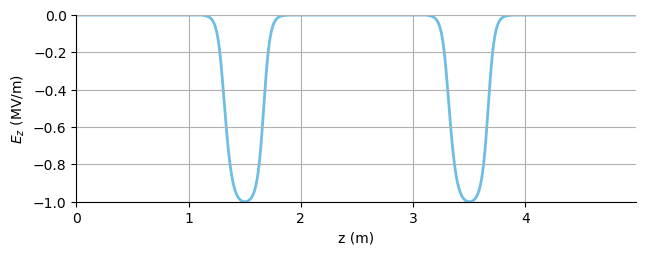

In [8]:
z  = acc.z
hv.Curve((z, acc.Ez(z)), kdims=dim_z, vdims=dim_Ez)

The same procedure is required to define the magnetic field profile $B_z(z)$:

In [9]:
#                 Unique name,  z-position [m],  Bz [T],  Bz(z) profile
acc.add_solenoid('Sol. 1',      1.0,             0.05,   'Bz.dat')
acc.add_solenoid('Sol. 2',      2.0,             0.06,   'Bz.dat')
acc.add_solenoid('Sol. 3',      3.0,             0.07,   'Bz.dat')
acc.add_solenoid('Sol. 4',      4.0,             0.08,   'Bz.dat')

In [10]:
acc.compile()

In [11]:
dim_Bz = hv.Dimension('Bz', unit='Gs', label='$B_z$')

In [12]:
z_Bz = hv.Curve((z, acc.Bz(z)*1e4), kdims=dim_z, vdims=dim_Bz)

:Curve   [z]   (Bz)
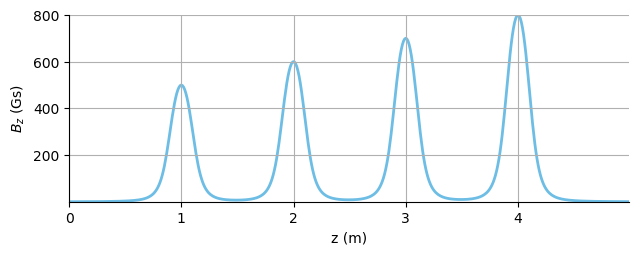

In [13]:
z_Bz

Define the electron beam parameters:

In [14]:
beam = kv.Beam(
    energy = 2,     # MeV
    current = 2e3,  # A
    radius = 50e-3, # initial r (m)
    rp = 10e-3,     # initial r' (rad)
    #x  = 2.5e-2,   # horizontal centroid position (m)
    xp = 10e-3,     # horizontal centroid angle (rad)
    y = 0,          # vertical centroid position (m)
    normalized_emittance = 1000e-6 # m*rad
)

Now we can run the simulation in order to find the beam envelope:

In [15]:
sim = kv.Simulation(beam, acc)

In [16]:
sim.track()

## Plot the simulation results:

In [17]:
dim_E = hv.Dimension('E', unit='MeV', label='Electron energy', range=(0,None))

:Curve   [z]   (E)
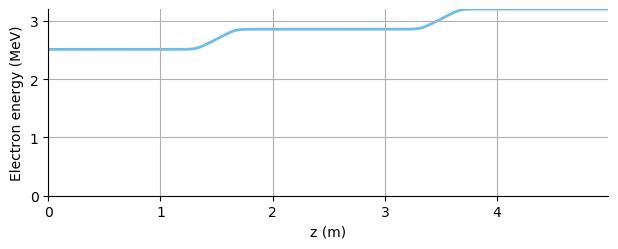

In [18]:
hv.Curve((z, sim.gamma(z)*0.511), kdims=dim_z, vdims=dim_E)

In [19]:
dim_x = hv.Dimension('x', unit='cm', range=(-15,+15))
dim_y = hv.Dimension('y', unit='cm', range=(-15,+15))

Beam centroid:

In [20]:
x = sim.centroid_x*100 # cm
z_x = hv.Curve((z, x), kdims=dim_z, vdims=dim_x).opts(linestyle='--')

:Curve   [z]   (x)
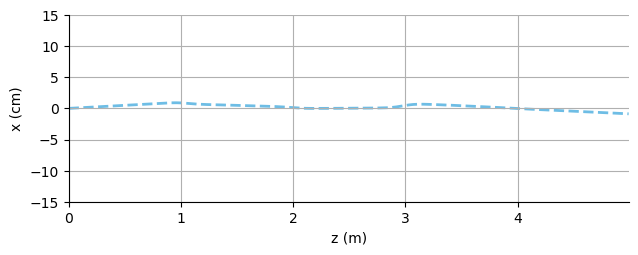

In [21]:
z_x

In [22]:
y = sim.centroid_y*100 # cm
z_y = hv.Curve((z, y), kdims=dim_z, vdims=dim_y).opts(linestyle='--')

:Curve   [z]   (y)
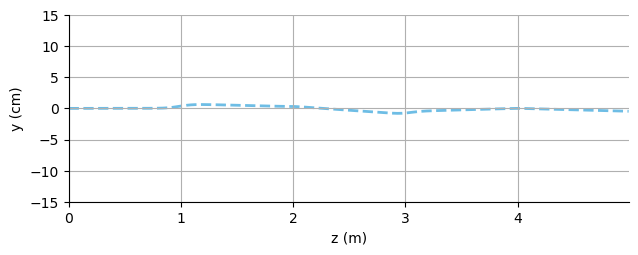

In [23]:
z_y

Beam envelope:

:Layout
   .Overlay.I :Overlay
      .Curve.I  :Curve   [z]   (x)
      .Spread.I :Spread   [x]   (y,yerror)
   .Curve.I   :Curve   [z]   (Bz)
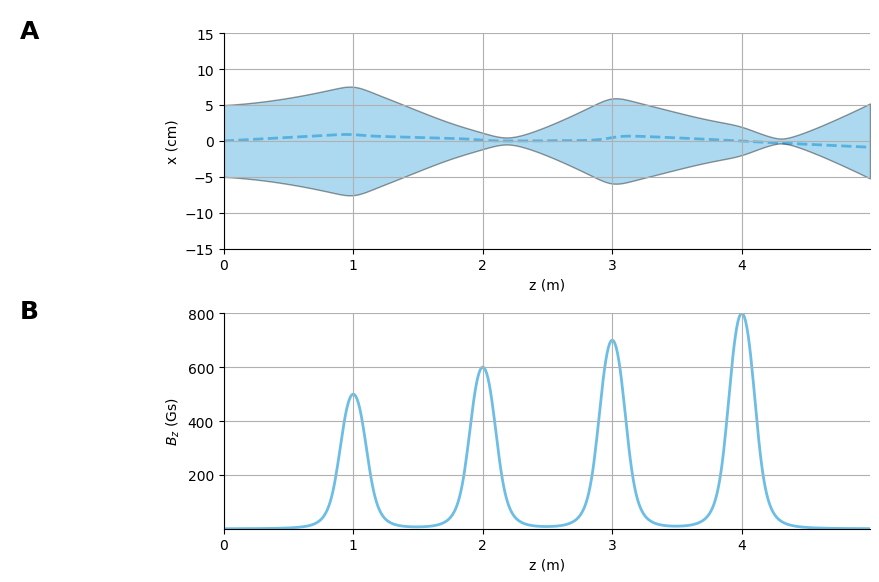

In [24]:
x_size = sim.envelope_x*100 # cm
(z_x * hv.Spread((z, 0, x_size)) + z_Bz).cols(1)

## Interactive plot

Now we can combine everything into one interactive plot to see the effect of different variables on the beam envelope.

In [29]:
%opts VLine (color='blue' linewidth=10 alpha=0.1)

def x_vs_Bz_plot(solenoid_B_Gs, beam_I):
    #global solenoid2vary
    
    beam.current = beam_I
    acc.Bz_beamline[solenoid2vary].max_field = solenoid_B_Gs/1e4
    
    acc.compile()
    
    sim = kv.Simulation(beam, acc)
    sim.track()
    
    z0 = acc.Bz_beamline[solenoid2vary].z0
    
    x = sim.centroid_x*100 # cm
    z_x = hv.Curve((z, x), kdims=dim_z, vdims=dim_x).opts(linestyle='--')
    
    x_size = sim.envelope_x*100 # cm
    x_img = z_x * hv.Spread((z, 0, x_size))
    
    z_Bz = hv.Curve((z, acc.Bz(z)*1e4), kdims=dim_z, vdims=dim_Bz)
    
    return (x_img*hv.VLine(z0) + z_Bz*hv.VLine(z0)).cols(1)

:DynamicMap   [Sol. 1,I]
   :Layout
      .Overlay.I  :Overlay
         .Curve.I  :Curve   [z]   (x)
         .Spread.I :Spread   [x]   (y,yerror)
         .VLine.I  :VLine   [x,y]
      .Overlay.II :Overlay
         .Curve.I :Curve   [z]   (Bz)
         .VLine.I :VLine   [x,y]
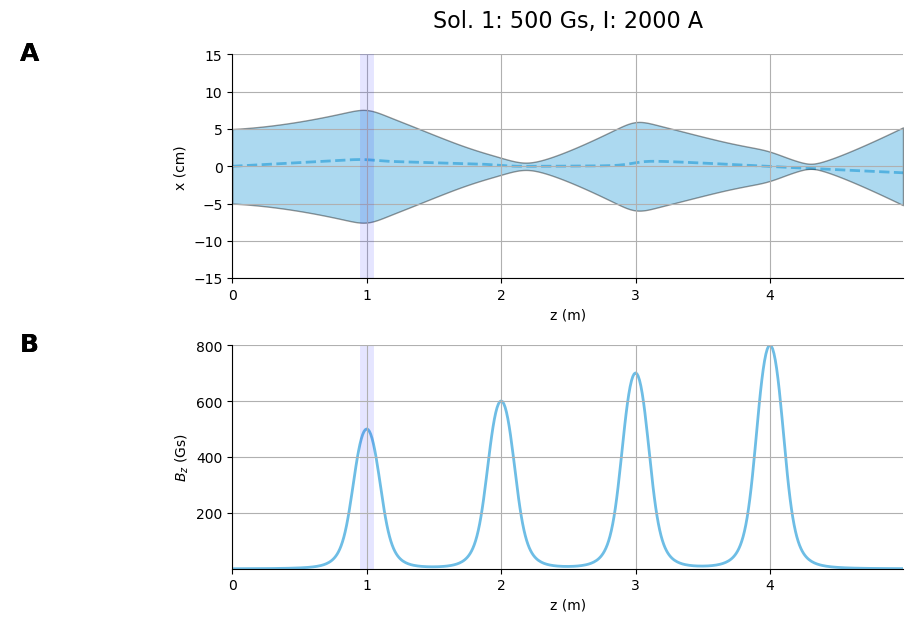

In [30]:
solenoid2vary = 'Sol. 1'

B0 = acc.Bz_beamline[solenoid2vary].max_field # T
dim_sol_B = hv.Dimension(solenoid2vary,  unit='Gs', range=(0, 1000), default=B0*1e4)

dim_I = hv.Dimension("I", unit='A', range=(0, 3000), default=beam.current)

dmap = hv.DynamicMap(x_vs_Bz_plot, kdims=[dim_sol_B, dim_I])
dmap

In [27]:
print(acc)

Accelerator structure.
	Solenoids:
	[ 1.00000 m, 0.05000 T, 'Bz.dat', 'Sol. 1'],
	[ 2.00000 m, 0.06000 T, 'Bz.dat', 'Sol. 2'],
	[ 3.00000 m, 0.07000 T, 'Bz.dat', 'Sol. 3'],
	[ 4.00000 m, 0.08000 T, 'Bz.dat', 'Sol. 4'],
	Accelerating modules:
	[ 1.50000 m, -1.00000 Mv/m, 'Ez.dat', 'Acc. 1'],
	[ 3.50000 m, -1.00000 Mv/m, 'Ez.dat', 'Acc. 2'],
	Quadrupoles:



In [28]:
print(beam)

Beam parameters:
	Current	2000.0 A
	Energy	2.0 MeV
	Radius x	50.0 mm
	Radius y	50.0 mm
	Radius x prime	10.0 mrad
	Radius y prime	10.0 mrad
	Horizontal centroid position	0.0 mm
	Vertical centroid position	0.0 mm
	Horizontal centroid angle	10.0 mm
	Vertical centroid angle	0.0 mm
	Larmor angle	0.0 mrad
	Normalized emittance x	1000.0 mm*mrad
	Normalized emittance y	1000.0 mm*mrad

